# Build your own NSFW Image Detector with Tensorflow

## Intro

In the age of the internet, the abundance of content also means an influx of potentially explicit or NSFW (Not Safe for Work) material. Detecting and filtering such content has become a pressing necessity for platforms and individuals alike. In this blog post, we'll explore how to create an NSFW image detector using TensorFlow and Python. TensorFlow, a powerful machine learning framework, will be our tool of choice for this task, offering flexibility and scalability.

By the end of this guide, you'll have not only a functioning NSFW image detector but also a solid understanding of how deep learning models work and how to apply them to real-world issues. Whether you're a platform administrator striving to maintain a safe environment or someone eager to delve into the world of machine learning, join us on this journey to enhance online safety and security.

## Prerequisites

The required libraries are listed in files ```requirements.txt``` which can be installed using ```pip install -r requirements.txt```

You can get the dataset by scraping the urls in ```raw_data``` folder. (It is very messy!)

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


We are going to split the data into train-validation-test

## Create train dataset

In [2]:
data_dir = os.path.join(os.getcwd(),'images')

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11178 files belonging to 5 classes.
Using 8943 files for training.


## Create validation dataset

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11178 files belonging to 5 classes.
Using 2235 files for validation.


## Create test dataset

In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

Check class labels of training data

In [5]:
class_names = train_ds.class_names
print(class_names)

['drawings', 'hentai', 'neutral', 'porn', 'sexy']


Uncomment this block of code to get a preview of the images. I'm warning you it's NSFW!!

In [6]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Configure the dataset for performance

When you're working with a lot of pictures or information, it's important to do it in a way that doesn't slow down your computer. We need to ensure the implementation of buffered prefetching to enable non-blocking data retrieval from disk. There are two critical techniques to employ when handling data loading:

1. Dataset.cache: This function stores images in memory after they've been initially loaded from disk during the first training epoch. This approach prevents the dataset from slowing down your model training process. Additionally, if your dataset is too large to fit entirely into memory, you can utilize this method to establish an efficient on-disk cache.

2. Dataset.prefetch: This function optimizes your workflow by running data preprocessing and model execution in parallel during training. This parallelism further enhances the training efficiency.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create basic model

Within the Keras Sequential model architecture, we've incorporated a stack of three convolutional blocks, utilizing the tf.keras.layers.Conv2D layers. Each of these blocks is accompanied by a corresponding tf.keras.layers.MaxPooling2D layer for down-sampling and feature extraction.

Above these convolutional layers, there exists a fully-connected layer (tf.keras.layers.Dense) comprising 128 neurons. These neurons are activated using the Rectified Linear Unit (ReLU) activation function ('relu').

It's important to note that our model hasn't undergone extensive fine-tuning for optimal accuracy. Our primary objective in this tutorial is to demonstrate a standard architectural approach, not to achieve peak performance.

The RGB channel values are usually confined to the [0, 255] range. Yet, for optimal neural network performance, it's advisable to keep your input values relatively small.

In this instance, we'll adjust the values to fit within the [0, 1] range. This transformation will be accomplished by employing the ```tf.keras.layers.Rescaling``` method

In [59]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [12]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
280/280 [==============================] - 210s 483ms/step - loss: 1.3084 - accuracy: 0.4506 - val_loss: 1.1058 - val_accuracy: 0.5652
Epoch 2/10
280/280 [==============================] - 124s 443ms/step - loss: 0.9716 - accuracy: 0.6248 - val_loss: 1.0153 - val_accuracy: 0.6088
Epoch 3/10
280/280 [==============================] - 112s 399ms/step - loss: 0.7912 - accuracy: 0.6991 - val_loss: 0.9351 - val_accuracy: 0.6301
Epoch 4/10
280/280 [==============================] - 112s 400ms/step - loss: 0.5900 - accuracy: 0.7785 - val_loss: 0.8956 - val_accuracy: 0.6631
Epoch 5/10
280/280 [==============================] - 118s 422ms/step - loss: 0.3955 - accuracy: 0.8580 - val_loss: 1.0494 - val_accuracy: 0.6558
Epoch 6/10
280/280 [==============================] - 126s 451ms/step - loss: 0.2129 - accuracy: 0.9253 - val_loss: 1.5300 - val_accuracy: 0.6049
Epoch 7/10
280/280 [==============================] - 137s 491ms/step - loss: 0.1194 - accuracy: 0.9639 - val_loss: 1.6595 -

## Visualize training results

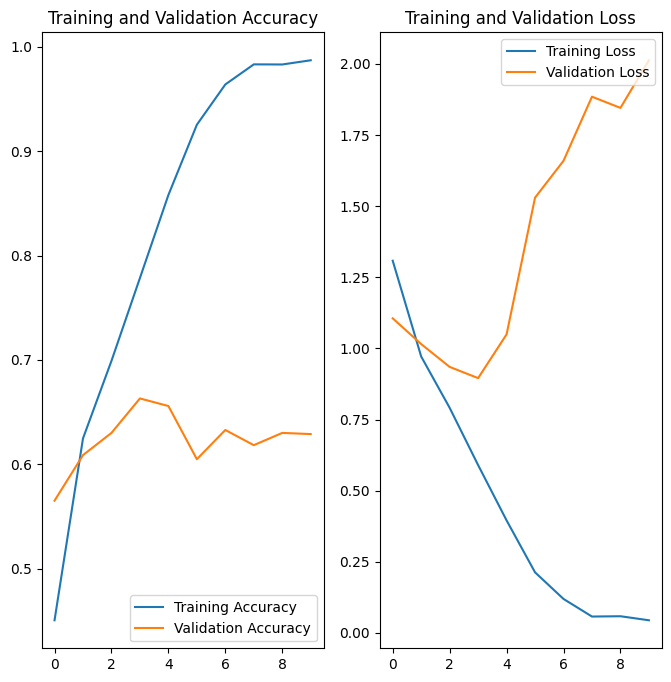

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The graphs show that the model is not doing well on new data. While it's getting better at the training data, it's kind of stuck at around 60% accuracy on the new data.

In those pictures, the line for training accuracy goes up steadily, but the line for new data accuracy stays at 60% and doesn't move much. This gap between training and new data performance is a sign of a problem called "overfitting."

Overfitting happens when the model learns too much from the training data, even the things it shouldn't. This makes it struggle when it encounters new, unfamiliar data.

We can confirm the overfitting issue by evaluating the model with unseen ```test data```

In [14]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 6s 279ms/step - loss: 1.6978 - accuracy: 0.6786
Test accuracy : 0.6785714030265808


Model's accuracy against test data is closer to the validation accuracy rather than train accuracy, this is an example of overfitting. To fix this, we can use some techniques like data augmentation and dropout, which we'll learn about in this tutorial. These techniques help the model do better with new data. For now, let's examine the model's behaviour against test data by plotting its confusion matrix

In [15]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test = list(map(lambda x: class_names[x],y_test))

In [16]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 2s 96ms/step


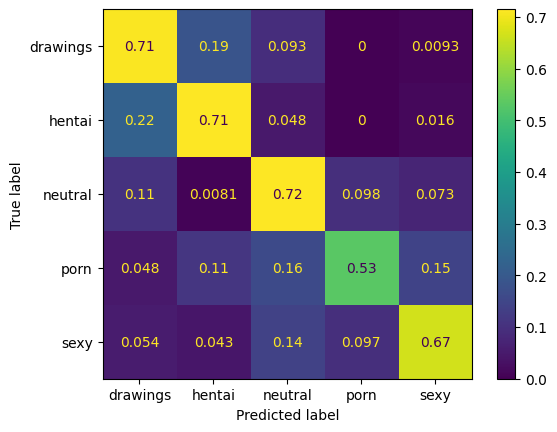

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

Confusion matrix above displayed as a percentage against it rows. Some interesting takeaways are:
1. The model often missclassified hentai with drawings and vice versa
2. The model doesn't do well in identifying porn images
3. The model seems to have a problem in classifying between porn, sexy and neutral images

Below is confusion matrix with actual number of images 

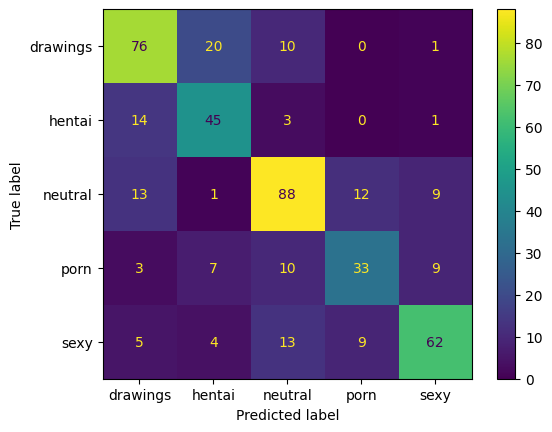

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

## Data Augmentation


Overfitting often happens when you don't have many training examples. Data augmentation tackles this problem by creating more training data from the ones you already have. It does this by making small changes to your existing pictures to create new ones that still look realistic. This way, your model gets to see different versions of the same data and becomes better at understanding it.

To do this, we'll use special tools like tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Uncomment this block of code to get a preview of flipped/rotated/zoomed images. I'm warning you AGAIN it's NSFW!!

In [20]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

## Layer Dropout

Another way to tackle overfitting is by using dropout regularization in your network.

It randomly turns off (makes it zero) some of the units in that layer during training. Dropout is controlled by a small number, like 0.1, 0.2, or 0.4. For example, if you set it to 0.1, it means randomly turning off 10% of the units in that layer.

To try this out, you can add a new feature to your neural network called tf.keras.layers.Dropout. This will help you reduce overfitting when you're training your network with the augmented images.

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compile and train

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
280/280 [==============================] - 156s 551ms/step - loss: 1.3330 - accuracy: 0.4421 - val_loss: 1.2940 - val_accuracy: 0.4734
Epoch 2/20
280/280 [==============================] - 157s 562ms/step - loss: 1.0875 - accuracy: 0.5620 - val_loss: 1.1388 - val_accuracy: 0.5445
Epoch 3/20
280/280 [==============================] - 155s 555ms/step - loss: 1.0092 - accuracy: 0.5987 - val_loss: 1.1653 - val_accuracy: 0.5730
Epoch 4/20
280/280 [==============================] - 161s 574ms/step - loss: 0.9631 - accuracy: 0.6186 - val_loss: 1.2187 - val_accuracy: 0.5658
Epoch 5/20
280/280 [==============================] - 159s 567ms/step - loss: 0.9405 - accuracy: 0.6243 - val_loss: 1.0907 - val_accuracy: 0.5859
Epoch 6/20
280/280 [==============================] - 157s 560ms/step - loss: 0.9092 - accuracy: 0.6413 - val_loss: 1.1713 - val_accuracy: 0.5686
Epoch 7/20
280/280 [==============================] - 152s 544ms/step - loss: 0.8812 - accuracy: 0.6522 - val_loss: 1.0304 -

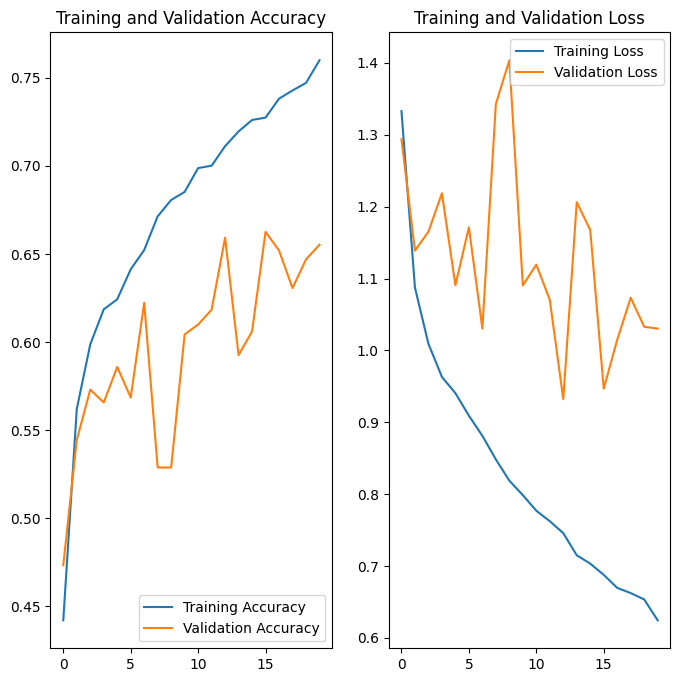

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Once we've used data augmentation and added tf.keras.layers.Dropout, the problem of overfitting becomes less severe compared to the previous situation. As a result, the accuracy in both training and validation is now more similar and balanced.

In [26]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 2s 122ms/step - loss: 1.0323 - accuracy: 0.6384
Test accuracy : 0.6383928656578064


Unfortunately, the model performs similarly or even worse than our initial model. Let's investigate the confusion matrix

In [27]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 2s 95ms/step


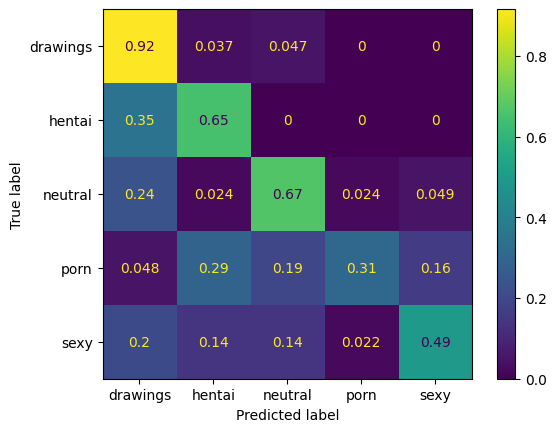

In [28]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

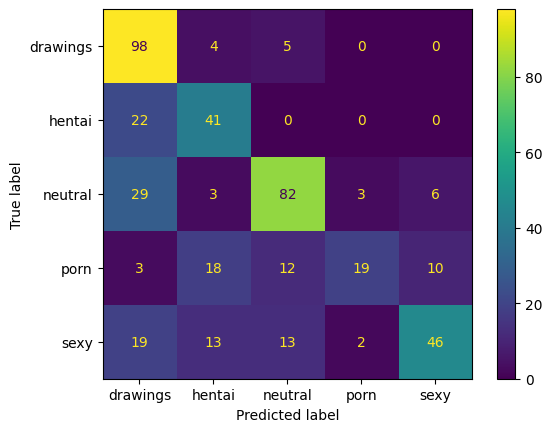

In [29]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

There's a tradeoff of performance. While the model does better in classifying drawings, it get's slightly worse on other class and significantly worse on porn images.

## Conclusion

Congratulations! You have created a custom basic neural network to classify NSFW images. There's still room for improvement, one way to get a better model is by using pretrained computer vision model instead of build it from scratch as we did in this tutorial. In the next part we will explore the steps to do this method called transfer learning.

# Transfer Learning

In this tutorial, you'll discover how to classify NSFW (Not Safe for Work) images using a technique called transfer learning from a pre-trained network.

A pre-trained model is like a smart student who has already studied a lot of pictures and learned from them. You can use this smart student's knowledge as a starting point for your own learning task.

The idea behind transfer learning for image classification is that if a model has learned a lot about the visual world from a big dataset, you can use its knowledge to help you with your own image classification task. Instead of starting from scratch, you can build on what this model already knows.

In this tutorial, we'll explore two ways to customize a pre-trained model:

1. Feature Extraction: Think of this like using a pre-trained artist's brushes to paint a new picture. You take the useful things the model learned before and add a new part (classifier) to help it classify your pictures.

2. Fine-Tuning: It's like making some small adjustments for a pre-trained artist to make them even better at a specific style of art. You'll change a few things in the pre-trained model to make it work really well for your specific classification task.

## Create the base model from the pre-trained model

You'll begin by using MobileNet V2, a smart model made by Google. It has learned a lot from a massive dataset called ImageNet, which has tons of pictures of different things like fruits and tools. This knowledge will help us identify NSF images in our own collection of pictures.

Now, to make the best use of MobileNet V2, we'll pick a special part of it for feature extraction. We don't want the very last part because it's not so useful for us. Instead, we'll grab the part just before everything gets flattende, which we call the "bottleneck layer." This layer knows more general stuff, which is what we need.

To set this up, we'll get a MobileNet V2 model that's already learned from ImageNet. But we'll leave out the top part where it does the final classification. That way, we can use it for our own classification job.

In [30]:
IMG_SHAPE = (img_height, img_width)+(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

## Feature Extraction

Now, in this step, we're going to keep the special part we made earlier just as it is (treating it like a feature collector) . Then, we'll add a new part on top, and teach it to do a specific job.

### Freeze the convolutional base

Before you proceed to compile and train your model, it's essential to freeze the convolutional base. By freezing it is preventing the weights within a specific layer from getting updated during training. Since MobileNet V2 consists of numerous layers, setting the entire model's "trainable" flag to False effectively freezes all of them. This action ensures that the knowledge acquired by these layers from the initial dataset remains intact and isn't altered during the subsequent training process.

In [31]:
base_model.trainable = False

In [32]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 90, 90, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 90, 90, 32)           0         ['bn_Conv1[

## Add a classification head

To create predictions from the set of features, we'll calculate the average value across all the different parts of the image (like a grid of 5x5 squares). This will compress all the information into a single list of 1280 numbers for each image. We'll achieve this using a tool called tf.keras.layers.GlobalAveragePooling2D.

In [33]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

In [34]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

Next, we'll use a tf.keras.layers.Dense layer to transform these features into a single prediction for each image. No activation function is necessary in this step because this prediction will be treated as a logit, which means it's a raw prediction value.

In [35]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


We'll use preprocessing layer from mobilenet. It is a similar layer with rescaling layer that we did in our own custom model.

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Create a model by linking the data augmentation, rescaling, base_model, and feature extractor layers using the Keras Functional API. Set the training parameter to False because our model includes a BatchNormalization layer.

In [37]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 180, 180, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                             

# Compile and train

In [39]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

56/56 [==============================] - 27s 465ms/step - loss: 2.2837 - accuracy: 0.2059


In [41]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.28
initial accuracy: 0.21


In [42]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
280/280 [==============================] - 182s 640ms/step - loss: 1.4874 - accuracy: 0.4200 - val_loss: 0.9498 - val_accuracy: 0.6301
Epoch 2/10
280/280 [==============================] - 173s 619ms/step - loss: 0.9373 - accuracy: 0.6385 - val_loss: 0.7124 - val_accuracy: 0.7392
Epoch 3/10
280/280 [==============================] - 174s 620ms/step - loss: 0.7681 - accuracy: 0.7042 - val_loss: 0.6286 - val_accuracy: 0.7750
Epoch 4/10
280/280 [==============================] - 188s 671ms/step - loss: 0.7163 - accuracy: 0.7316 - val_loss: 0.5879 - val_accuracy: 0.7941
Epoch 5/10
280/280 [==============================] - 185s 661ms/step - loss: 0.6678 - accuracy: 0.7518 - val_loss: 0.5628 - val_accuracy: 0.8019
Epoch 6/10
280/280 [==============================] - 184s 656ms/step - loss: 0.6398 - accuracy: 0.7571 - val_loss: 0.5516 - val_accuracy: 0.8041
Epoch 7/10
280/280 [==============================] - 170s 609ms/step - loss: 0.6141 - accuracy: 0.7771 - val_loss: 0.5471 -

In [43]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 7s 493ms/step - loss: 0.4871 - accuracy: 0.8192
Test accuracy : 0.8191964030265808


Model's accuracy in test data is significantly higher than our previous model. This demonstrate how useful transfer learning is in building our own neural network

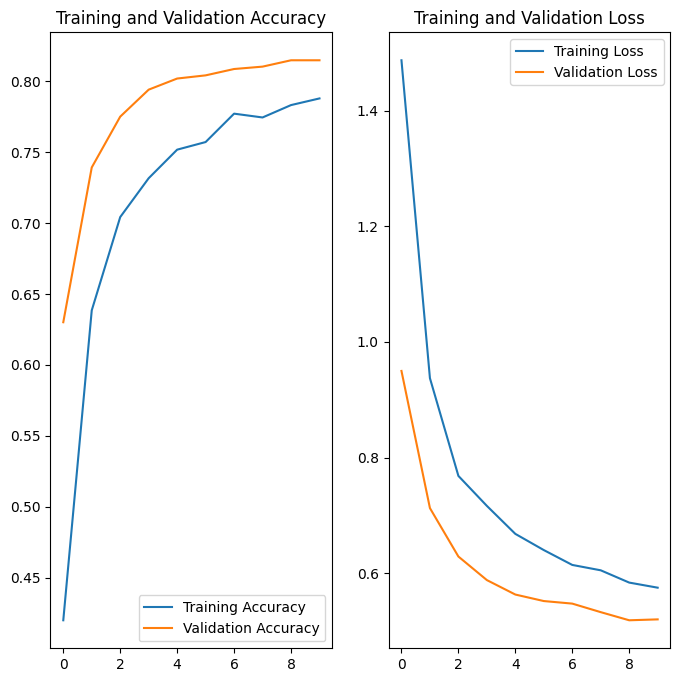

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 8s 482ms/step


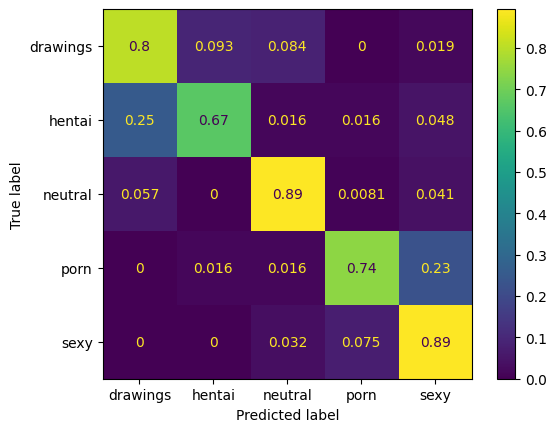

In [46]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

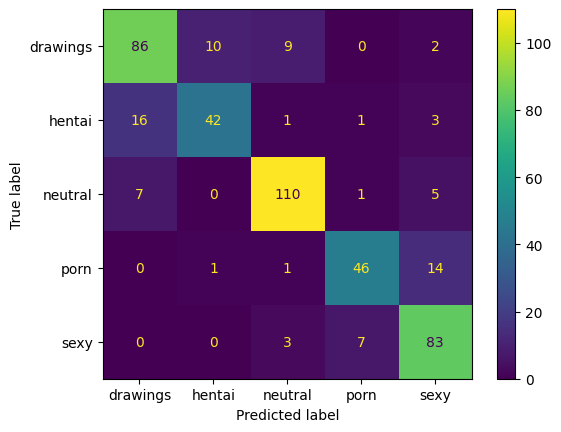

In [47]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Some interesting takeawyas from the confusion matrix:
1. Overall performance is already better than our own custom model
2. This model still have difficulty in differentiating between drawings and hentai as well as porn and sexy images

I would say, this model performs satisfactory for demonstration purposes. But we can try to adjust this model to our specific dataset by doing fine tuning.

# Fine Tuning

In the previous part, when we did feature extraction, we didn't change the pre-trained MobileNetV2 model. We just added a few new layers on top to help with our specific task.

Now, if we want to make our model even better, we can do something called "fine-tuning." This means we'll adjust the weights of some top layers in the pre-trained model while training our new layers. This way, the model will learn to recognize things that are important for our particular dataset.

 Rather than fine-tuning every layer in the pre-trained model, We should try to fine-tune a small number of top layers. The lower layers learned basic stuff that's useful for almost any picture. As we move up in the layers, they learned things specific to the dataset they were trained on. So, when we fine-tune, we're mainly tweaking the specialized stuff to fit our dataset better, without forgetting the general knowledge.

### Un-freeze the top layers of the mode

We are going to unfreeze the ```base_model`` and keep the bottom layers to be freezed. Then, recompile and resume training.

In [48]:
base_model.trainable = True

In [49]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [50]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 180, 180, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                             

In [52]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
280/280 [==============================] - 252s 877ms/step - loss: 0.5411 - accuracy: 0.7964 - val_loss: 0.4720 - val_accuracy: 0.8288
Epoch 11/20
280/280 [==============================] - 262s 937ms/step - loss: 0.4688 - accuracy: 0.8256 - val_loss: 0.4384 - val_accuracy: 0.8304
Epoch 12/20
280/280 [==============================] - 245s 875ms/step - loss: 0.4267 - accuracy: 0.8397 - val_loss: 0.4167 - val_accuracy: 0.8400
Epoch 13/20
280/280 [==============================] - 242s 865ms/step - loss: 0.3995 - accuracy: 0.8473 - val_loss: 0.4153 - val_accuracy: 0.8416
Epoch 14/20
280/280 [==============================] - 263s 941ms/step - loss: 0.3718 - accuracy: 0.8631 - val_loss: 0.4082 - val_accuracy: 0.8450
Epoch 15/20
280/280 [==============================] - 250s 893ms/step - loss: 0.3500 - accuracy: 0.8693 - val_loss: 0.4126 - val_accuracy: 0.8444
Epoch 16/20
280/280 [==============================] - 235s 839ms/step - loss: 0.3321 - accuracy: 0.8752 - val_loss: 0

In [53]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

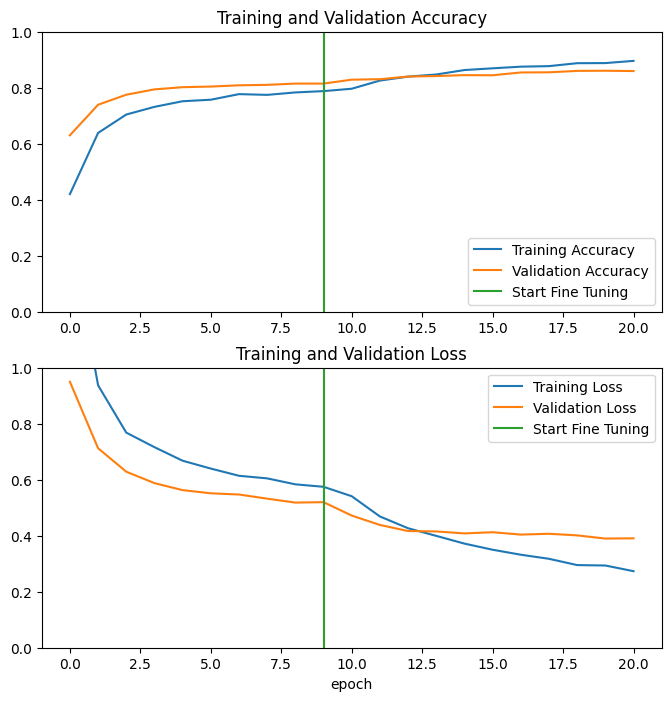

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

One thing to take note is fine-tuning is prone to overfitting as we see in the graph above after 11 epoch the training accuracy keep increasing while validation training stay more or less the same.

In [55]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 7s 496ms/step - loss: 0.3672 - accuracy: 0.8571
Test accuracy : 0.8571428656578064


We gain a bit more increase in model performance. Let's investigate the confusion matrix.

In [56]:
y_prob= model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

14/14 [==============================] - 8s 489ms/step


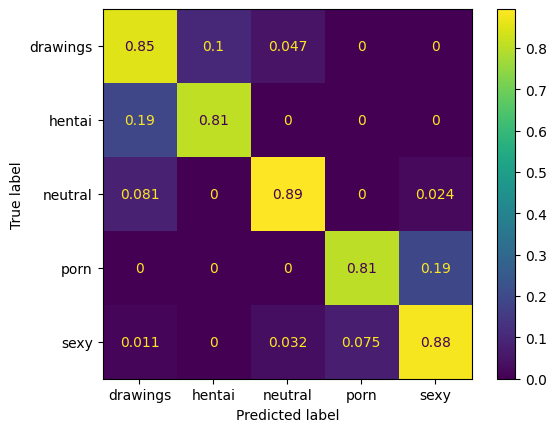

In [57]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

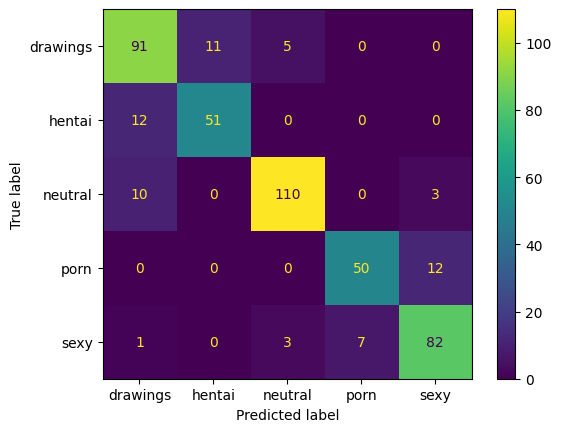

In [58]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Although this fine-tuned model still has some behaviour as previous model, such as missclassifying hentai with drawings and porn with sexy images, the ability to recognize hentai images significantly increase while maintaining performance in other classes.

Let's save this model to be used in future projects.

In [60]:
model.save('nsfw_mobilenet_fine_tuned.keras')

## Conclusion

Congratulations! You've reached the end of this 2 part tutorial on building an NSFW image classifier with TensorFlow. We've covered a lot of ground, and you've acquired some powerful skills in deep learning and computer vision.

Throughout this journey, we've explored the importance of responsible content filtering in today's digital landscape and delved into the inner workings of convolutional neural networks, data augmentation, dropout regularization, transfer learning and fine-tuning.

We encourage you to continue experimenting, learning, and sharing your insights with the world. The future holds exciting opportunities in the field of artificial intelligence, and you are well-equipped to be a part of it.

Thank you for joining me on this educational journey, and I hope this tutorial will help you to further improve your skills and interest in deep learning.